# Critical number of users versus $k$

In [1]:
import numpy as np
import math
import importlib as imp
import QCSsimulator as sim
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm as tqdmn

## Fixed parameter values

In [2]:
# Requests
n_request = 7 # Number of entanglements requested per request
request_rate = 1e-4 # [1/us] Request submission rate per pair of users

$n$ only affects the service time distribution. When computing $u_\mathrm{crit}$, we need the expected service time. Increasing $n$ would increase the expected service time but would not change the behavior of the system otherwise. Nevertheless, a large $n$ would increase the runtime of the simulation (and the analytics, since we need to compute more combinations of successful patterns). Hence, we choose a nontrivial value of $n$ that is not too large.

$\lambda_0$ has a similar effect, since it multiplies $\mathbb{E}\left[T_\mathrm{service}\right]$ in the calculation of $u_\mathrm{crit}$. If $\lambda_0$ is very small/large, the critical number of users will shift towards larger/smaller values. We choose a value of $\lambda_0$ that provides interesting behavior for reasonable numbers of users (other values of $\lambda_0$ would only shift the region of interest towards larger or smaller values of the other parameters).

In [3]:
# Hardware
k_vec = np.arange(1,20+1,1) # Number of forwarding devices
fwd_time_0 = 100 # [us] Forwarding time

We focus on a range of values of $k$ that provides interesting behavior.

The forwarding time of each forwarding station is assumed to be 100 $\mu$s. This estimate is for qubits realized with color centers (such as nitrogen vacancies). A gate on those qubits takes around 1-50 $\mu$s, and approximately ten gates (order of magnitude) are needed to forward a quantum data packet.

In [4]:
# Reference units
speed_light = 0.2 # [km/us] Speed of light in optical fiber

We assume the physical channels between users are optical fibers in which the speed of light is approximately $0.2$ km/$\mu$s.

In [5]:
# Other
control_time = 0

We assume negligible control time, since this does not affect the load of the system, which is used to compute the critical number of users.

In [11]:
# Other
distributions = ['sequential', 'parallel']

# Plots
dark = False
savefig = True

---
---
## Use case $I$: small budget

In this case, we use the low-cost forwarding stations from Borregaard2020, which provide $p=1$ over short distances $L_0 \sim 1$ km. As a consequence, the size of the window does not matter as long as $w\geq n$.

Since the budget is limited, we can only afford a single central repeater, i.e., $N=0$. This limits the total size of the network to short distances: $L = 1$ km.

In [12]:
# Probability of successful packet
p = 1


# Request window
w_request = 10 # [us]


# Number of repeaters between each user and the central repeater
N = 0

# Forwarding time
fwd_time = fwd_time_0


# User-center distance
L = 1 # [km]
travel_time = 2*L/speed_light


# Numerical
run_simulation = False

sequential:   0%|          | 0/20 [00:00<?, ?it/s]

parallel:   0%|          | 0/20 [00:00<?, ?it/s]

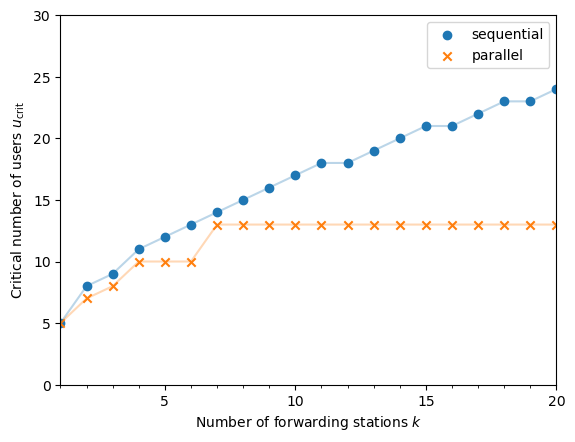

In [13]:
imp.reload(sim)

## Calculate critical number of users ##
crit_u_vec = [np.zeros(len(k_vec)) for d in distributions]

for idx_distrib, distribution in enumerate(distributions):
    for idx_k in tqdmn(range(len(k_vec)), distribution, leave=False):
        k = k_vec[idx_k]
        
        crit_u_vec[idx_distrib][idx_k] = sim.find_critical_u(distribution, n_request, w_request, 
                                                             p, k, request_rate, fwd_time, N, travel_time,
                                                             run_simulation=run_simulation)

## Plot params ##
xlimvec = [k_vec[0], k_vec[-1]]
ylimvec = [0, 30]#np.max(crit_u_vec)*1.1]
colors = ['tab:blue', 'tab:orange']
markers = ['o','x']
linestyles = ['-','-']


if dark==True:
    plt.style.use('dark_background')
    
## Plot ##
fig, ax = plt.subplots()

for idx_distrib, distribution in enumerate(distributions):
    plt.plot(k_vec, crit_u_vec[idx_distrib], color=colors[idx_distrib], alpha=0.3,
              linestyle=linestyles[idx_distrib])
    plt.scatter(k_vec, crit_u_vec[idx_distrib], color=colors[idx_distrib],
                marker=markers[idx_distrib], label=distribution)

plt.xlabel(r'Number of forwarding stations $k$')
plt.ylabel(r'Critical number of users $u_\mathrm{crit}$')
plt.xlim(xlimvec)
plt.ylim(ylimvec)
xticksvec = np.arange(5,xlimvec[-1]+1,5)
plt.xticks(ticks=xticksvec, labels=xticksvec)
ax.set_xticks(np.arange(xlimvec[0],xlimvec[-1],1), minor=True)
#ax.grid(which='both', axis='x', alpha=0.2)
plt.legend()

if savefig:
    if dark==True:
        filename = 'figs/DARK_'
    else:
        filename = 'figs/'
    filename += 'PAPER-ucrit_n%d_lambda%s_rawfwdtime%d_c%s_control%s'%(n_request, request_rate,
                                                                        fwd_time_0, speed_light, control_time)
    filename += '_p%.3f_w%d_N%d_L%s'%(p, w_request, N, L)
    if run_simulation:
        filename += '_Nsamples%d_randseed%d.pdf'%(N_samples, randomseed)
    else:
        filename += '.pdf'
    plt.savefig(filename, dpi=300, bbox_inches='tight')
else:
    plt.show()

---
---
## Use case $II$: unlimited-but-reasonable budget

In [14]:
# Increase the range of k for a better visualization
k_vec = np.arange(1,40+1,1)

In this case, we have an unlimited budget and we opt for a cost-efficient deployment. For this example, we assume [[48,6,8]] code and a repeater efficiency of $\eta_\mathrm{r}=0.9$. As shown in Niu2022, the optimal cost-efficient solution is then $p=0.7$, which requires $N=0,1,2,5$ repeaters between each user and the central repeater when $L=7.5,13,18,30$ km.

The window must be larger or equal to $n$. We consider $w = 7,8,10,\infty$ (recall that $n=7$).

In [15]:
N = 0
L = 7.5

L_0 = L/(N+1)
p = 10**(-sim.a_eff(L_0)*(2*L)/10)

print(p)

0.693715142540849


In [21]:
# Request window
w_request_vec = [7,8,10,np.inf] # [us]

# Forwarding time
fwd_time = fwd_time_0

# Number of repeaters between each user and the central repeater
N_vec = [0,1,2,5]

# User-center distance
L_vec = [7.5,13,18,30]

# Numerical
N_samples = int(1e6)
randomseed = 2

run_simulation = True
savefig = True

sequential:   0%|          | 0/40 [00:00<?, ?it/s]

parallel:   0%|          | 0/40 [00:00<?, ?it/s]

sequential:   0%|          | 0/40 [00:00<?, ?it/s]

parallel:   0%|          | 0/40 [00:00<?, ?it/s]

sequential:   0%|          | 0/40 [00:00<?, ?it/s]

parallel:   0%|          | 0/40 [00:00<?, ?it/s]

sequential:   0%|          | 0/40 [00:00<?, ?it/s]

parallel:   0%|          | 0/40 [00:00<?, ?it/s]

sequential:   0%|          | 0/40 [00:00<?, ?it/s]

parallel:   0%|          | 0/40 [00:00<?, ?it/s]

sequential:   0%|          | 0/40 [00:00<?, ?it/s]

parallel:   0%|          | 0/40 [00:00<?, ?it/s]

sequential:   0%|          | 0/40 [00:00<?, ?it/s]

parallel:   0%|          | 0/40 [00:00<?, ?it/s]

sequential:   0%|          | 0/40 [00:00<?, ?it/s]

parallel:   0%|          | 0/40 [00:00<?, ?it/s]

sequential:   0%|          | 0/40 [00:00<?, ?it/s]

parallel:   0%|          | 0/40 [00:00<?, ?it/s]

sequential:   0%|          | 0/40 [00:00<?, ?it/s]

parallel:   0%|          | 0/40 [00:00<?, ?it/s]

sequential:   0%|          | 0/40 [00:00<?, ?it/s]

parallel:   0%|          | 0/40 [00:00<?, ?it/s]

sequential:   0%|          | 0/40 [00:00<?, ?it/s]

parallel:   0%|          | 0/40 [00:00<?, ?it/s]

sequential:   0%|          | 0/40 [00:00<?, ?it/s]

parallel:   0%|          | 0/40 [00:00<?, ?it/s]

sequential:   0%|          | 0/40 [00:00<?, ?it/s]

parallel:   0%|          | 0/40 [00:00<?, ?it/s]

sequential:   0%|          | 0/40 [00:00<?, ?it/s]

parallel:   0%|          | 0/40 [00:00<?, ?it/s]

sequential:   0%|          | 0/40 [00:00<?, ?it/s]

parallel:   0%|          | 0/40 [00:00<?, ?it/s]

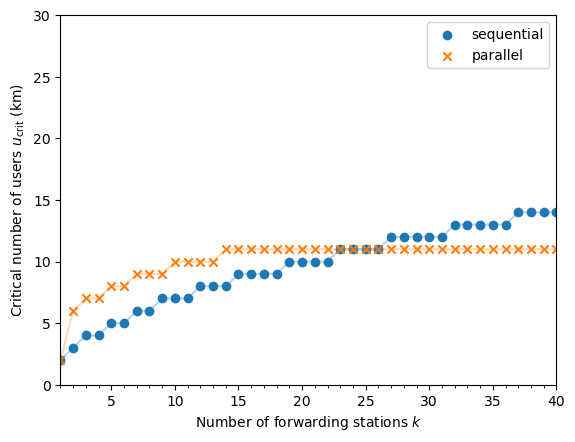

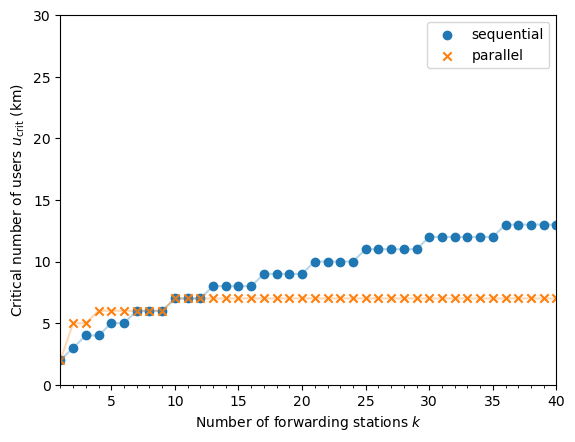

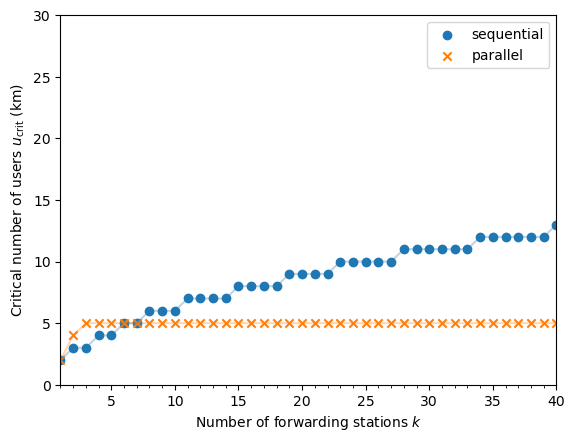

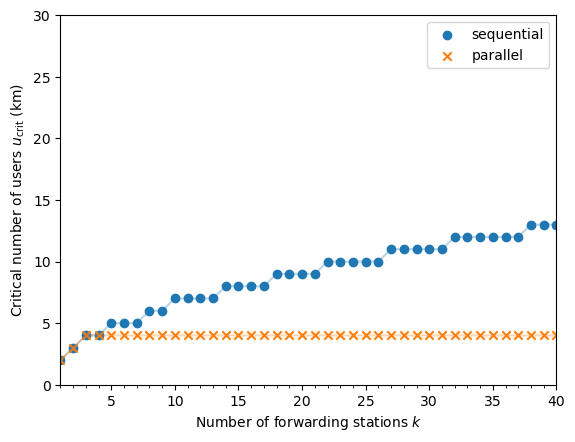

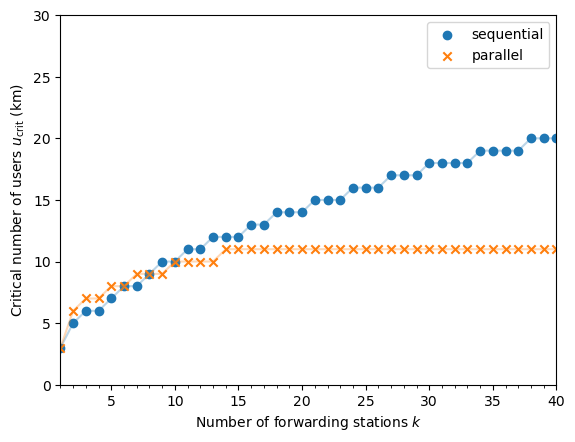

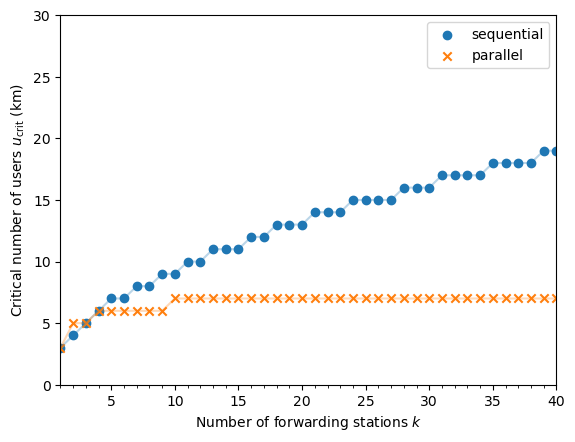

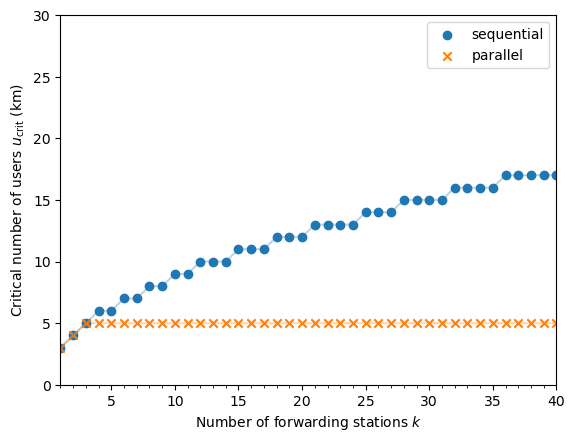

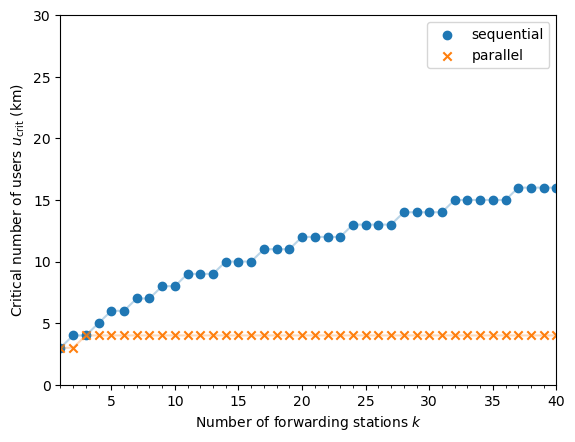

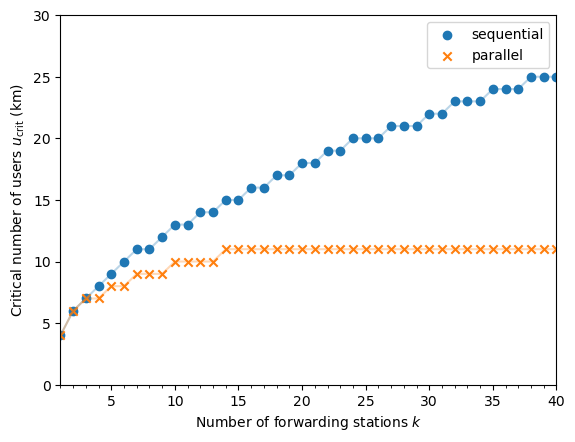

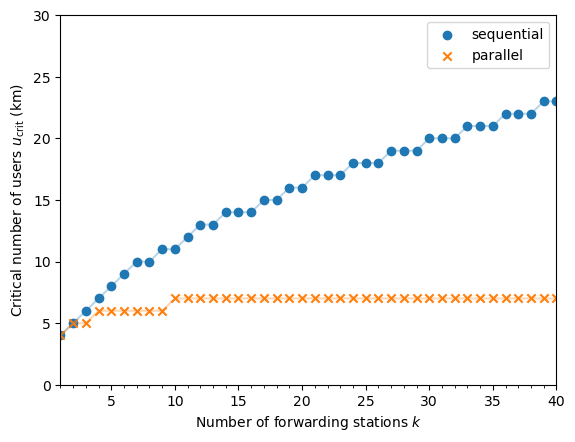

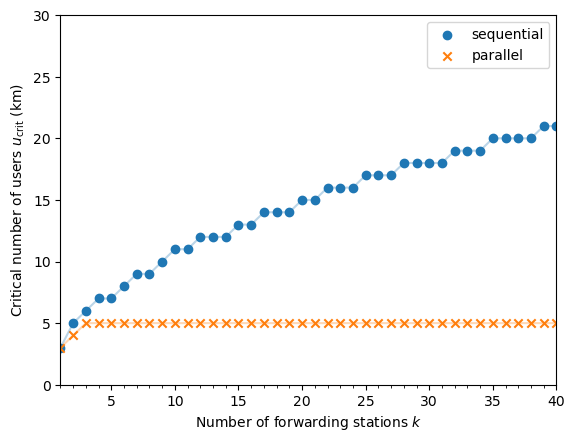

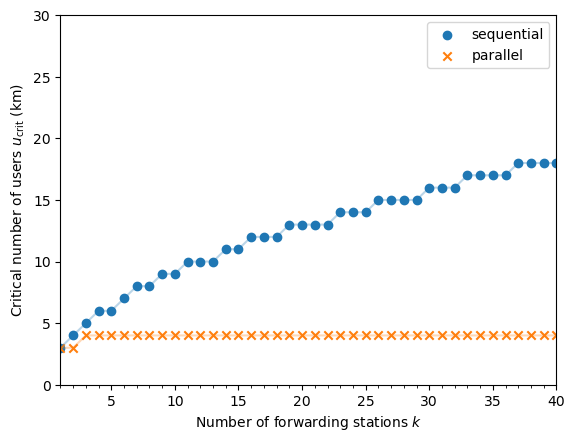

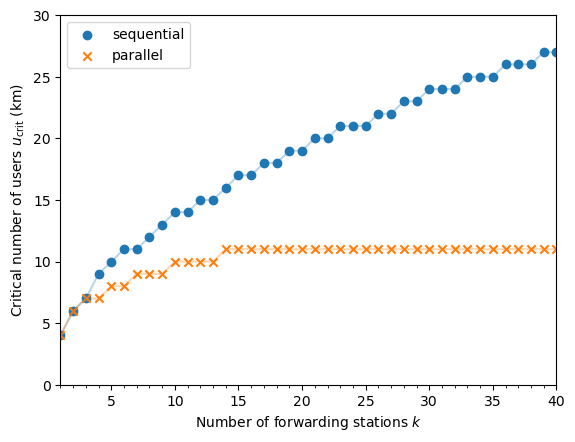

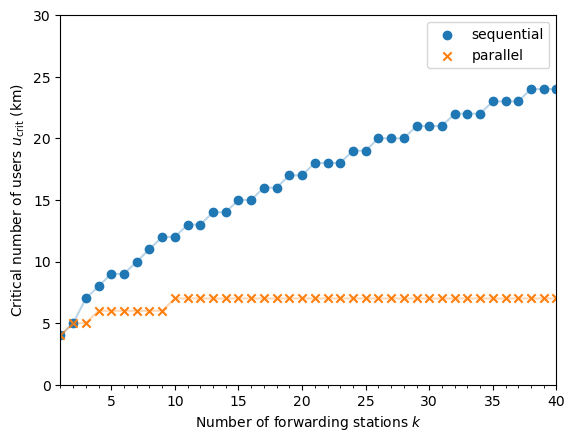

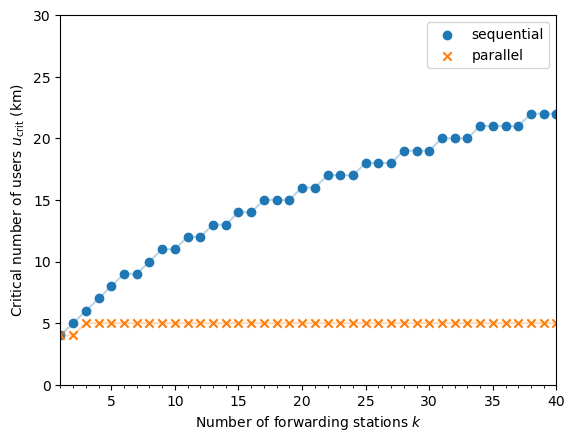

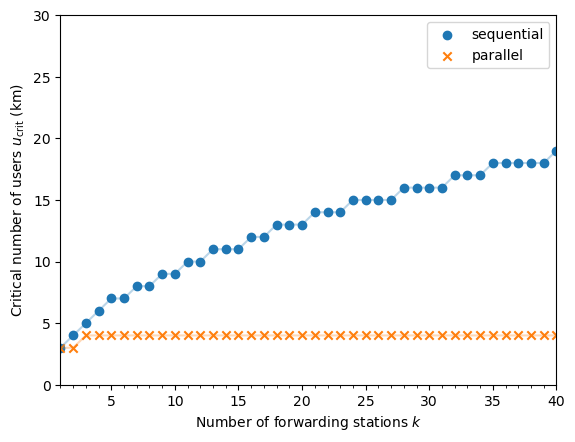

In [22]:
imp.reload(sim)

for w_request in w_request_vec:
    for N_idx, N in enumerate(N_vec):

        L = L_vec[N_idx]
        travel_time = 2*L/speed_light
        
        # Probability of successful packet
        p = 10**(-sim.a_eff(L/(N+1))*(2*L)/10)

        ## Calculate critical number of users ##
        crit_u_vec = [np.zeros(len(k_vec)) for d in distributions]

        for idx_distrib, distribution in enumerate(distributions):
            for idx_k in tqdmn(range(len(k_vec)), distribution, leave=False):
                k = k_vec[idx_k]

                crit_u_vec[idx_distrib][idx_k] = sim.find_critical_u(distribution, n_request, w_request, 
                                                                     p, k, request_rate, fwd_time, N, travel_time,
                                                                     run_simulation=run_simulation)

        ## Plot params ##
        xlimvec = [k_vec[0], k_vec[-1]]
        ylimvec = [0, 30]#np.max(crit_u_vec)*1.1]
        colors = ['tab:blue', 'tab:orange']
        markers = ['o','x']
        linestyles = ['-','-']


        if dark==True:
            plt.style.use('dark_background')

        ## Plot ##
        fig, ax = plt.subplots()

        for idx_distrib, distribution in enumerate(distributions):
            plt.plot(k_vec, crit_u_vec[idx_distrib], color=colors[idx_distrib], alpha=0.3,
                      linestyle=linestyles[idx_distrib])
            plt.scatter(k_vec, crit_u_vec[idx_distrib], color=colors[idx_distrib],
                        marker=markers[idx_distrib], label=distribution)

        plt.xlabel(r'Number of forwarding stations $k$')
        plt.ylabel(r'Critical number of users $u_\mathrm{crit}$ (km)')
        plt.xlim(xlimvec)
        plt.ylim(ylimvec)
        xticksvec = np.arange(5,xlimvec[-1]+1,5)
        plt.xticks(ticks=xticksvec, labels=xticksvec)
        ax.set_xticks(np.arange(xlimvec[0],xlimvec[-1],1), minor=True)
        #ax.grid(which='both', axis='x', alpha=0.2)
        plt.legend()

        if savefig:
            if dark==True:
                filename = 'figs/DARK_'
            else:
                filename = 'figs/'
            filename += 'PAPER-ucrit_n%d_lambda%s_rawfwdtime%d_c%s_control%s'%(n_request, request_rate,
                                                                                fwd_time_0, speed_light, control_time)
            filename += '_p%.3f_w%s_N%d_L%s'%(p, w_request, N, L)
            if run_simulation:
                filename += '_Nsamples%d_randseed%d.pdf'%(N_samples, randomseed)
            else:
                filename += '.pdf'
            plt.savefig(filename, dpi=300, bbox_inches='tight')
        else:
            plt.show()